In [149]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 14, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [268]:
class AnalyseDefectsAll:
    def __init__(self, system_size_list, ):
        self.LX = system_size_list
        self.inputs_paths = [f"data\\nematic_analysis{LX}_LL0.05\\merged_results" for LX in self.LX]
        self.act_list = [list(np.load(os.path.join(path, "activity_list.npy"))) for path in self.inputs_paths]
        self.window_sizes = [list(np.load(os.path.join(path, 'window_sizes.npy'))) for path in self.inputs_paths]
        self.Nactivity = [len(act) for act in self.act_list]

    def plot_av_defects(self, fit_dict = {}, act_bounds = None, plot_density = True, verbose = False,):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'param_guess': guess for the fit parameters
        """
 
        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            param_guess = fit_dict['param_guess']

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            norm = LX**2 if plot_density else 1

            try:
                av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
            except:
                print('Average defects not found. Analyse defects first.')
                return
   
            ax.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i], label = f'L = {self.LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
        
            if do_fit:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = self.act_list[i].index(act_bounds[0])
                    act_idx_bounds[1] = self.act_list[i].index(act_bounds[1]) + 1
     
                activities = np.array(self.act_list[i][act_idx_bounds[0]:act_idx_bounds[1]])
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                    fit = do_chi2_fit(fit_func, activities, av_defects[act_idx_bounds[0]:act_idx_bounds[1], 0], \
                                av_defects[act_idx_bounds[0]:act_idx_bounds[1], 1], parameter_guesses = param_guess, verbose=verbose)
                    Ndof, chi2, pval = get_statistics_from_fit(fit, len(activities), subtract_1dof_for_binning = False)

                  
                    print(f'For LX = {LX}:')
                    print("Valid minimum: ", fit.fmin.is_valid)
                    print('Params: ', fit.values[:])
                    print(f'Ndof = {Ndof}, chi2 = {chi2:.3f}, pval = {pval:.3f}\n')
                    
                #  d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                #  text = nice_string_output(d, extra_spacing=4, decimals=3)
                #  add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

                ax.plot(activities, fit_func(activities, *fit.values[:]), '-', color = f'C{i}', label=rf'Fit $L = {LX}$', linewidth = 2)
        
        if do_fit:
            ax.text(0.10, 0.95, rf'Fit = {fit_string}', transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')

        ax.legend(loc='lower right')
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')    
        fig.tight_layout()
        return fig, ax

    def plot_alpha_mean(self, use_density_fit = False, act_bounds = None):
        
        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
        for i, LX in enumerate(self.LX):
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
            
            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[i], label = f'L = {self.LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax

    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, act_bounds = None, verbose = False,):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='upper right', ncol=5)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()
        return fig, ax

    def plot_binder_cumulants(self, act_bounds_list = None, plot_binder = False,):
            
        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                binder = np.load(os.path.join(self.inputs_paths[i], 'binder_cumulants.npy'))
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]

            if act_bounds_list is None:
                act_idx_bounds = [0, len(act_list)]
                act_bounds = [act_list[0], act_list[-2]]
            else:
                act_bounds = act_bounds_list[i]
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            binder = binder[act_idx_bounds[0]:act_idx_bounds[1], :]

            if plot_binder:
                y = binder[:, 0]
                ylabel = r'$U_B(\rho)$'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'lower right'
            else:
                y = 2/3 - binder[:, 0]
                ylabel = r'$U(\rho)$'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'upper right'

            ax.errorbar(act_list, y, binder[:, 1], fmt = f'.-', label = f'L = {self.LX[i]}', elinewidth=1.5, \
                        capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
       
        ax.legend(loc=loc, ncol=2)
        ax.set_xlabel(r' $\zeta$ (activity)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()
        return fig, ax

    


In [269]:
system_size_list = [256, 512, 1024]
ada = AnalyseDefectsAll(system_size_list)

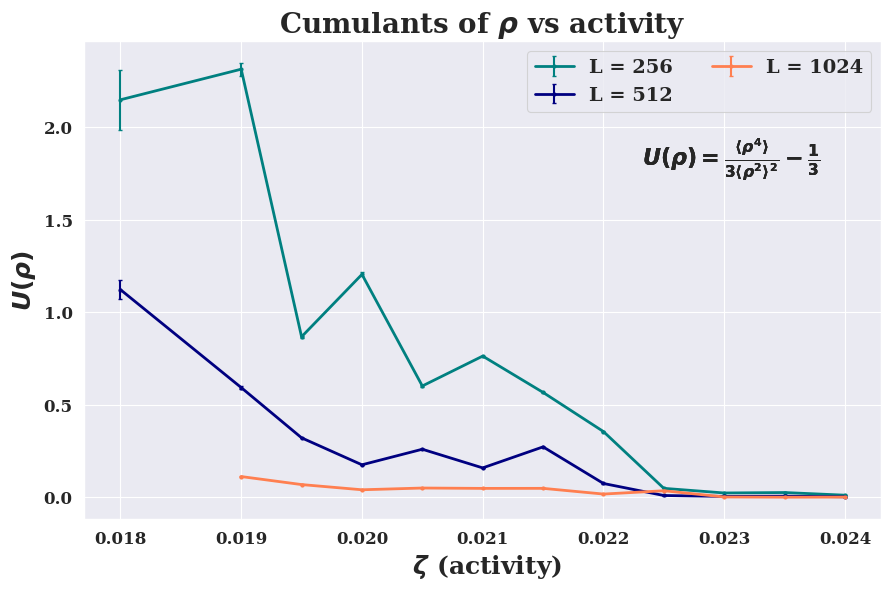

In [270]:
act_bounds_list = [[0.01, 0.024], [0.01, 0.024], [0.01, 0.024]]
ada.plot_binder_cumulants(act_bounds_list=act_bounds_list, plot_binder=False);

In [ ]:
window_idx_bounds_list = [[7, None], [0, None], [0, None]]
act_max_list = [0.022, 0.0215, 0.0215]    
fig, ax = ada.plot_susceptibility(act_bounds = [0, .04], window_idx_bounds_list = window_idx_bounds_list, act_max_list=act_max_list)
ax.set_ylim(0, 1.3)
ax.set_xlim(0.01, .04)

In [ ]:
ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.25]);

In [105]:
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
def linear(x, a, b):
    return a * x + b
def log(x, a, b):
    return a * np.log(x) + b
def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density

fit_func = logistic_func


fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_log = rf'$y = a \ln x + bx + c $'
fit_string_lin = rf'$y = a x + b$'
param_guess_log = np.array([0.005, 0.04,0.015])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.04,0.015])
param_guess_logistic = np.array([0.002, 2000, 0.023,])
fit_dict = dict(fit_func = logistic_func, fit_string = fit_string_lin, lower_act_index = 12, param_guess = param_guess_logistic)


In [ ]:
fig, ax = ada.plot_av_defects(fit_dict=fit_dict,act_bounds=[0.02, 0.025])
ax.set_xlim([0.018,0.032])
ax.set_ylim([0, 0.005])
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc='upper right')